# Krista, working on linking CO and KO
13 August 2015, 21 August 2015, 24 August 2015

This version will attempt to track KEGG compounds by a number unique to the mz/RT combination. This will allow us to track the isomers as needed.    

In [423]:
import pandas as pd
import urllib2
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import palettable as pal

%matplotlib inline

This version is using metabolites which can have isomers in KEGG, but are only found in either positive or negative ion mode (haven't dealt with the metabolites found in both yet).

In [424]:
#mtabFile = 'RImetabolites_unique.2015.08.19.csv' #this was the file with the mtabs that only have one isomer in KEGG
mtabFile = 'RImetabolites_isomers.2015.08.21.csv' #first column is RInumber

In [425]:
CO_RawData=pd.read_csv(mtabFile, index_col='RInumber')
#can immediately see the multiple iterations of a CO number right at the top five rows. 
#The compound labeled as C00079 shows up at least three times bc found at 
#different retention times. Need to track this since cNumber is not unique
##BUT, only matters in the Kmeans clustering, does not matter in the data gathering from KEGG
CO_RawData.head(n=5)

,cNumber,S1,S2,S3,S4,S5
RInumber,,,,,,
RI1,C00047,0.000841,0.001725,0.001201,0.000771,0.000604
RI2,C00078,0.005920,0.007708,0.003950,0.010562,0.027481
RI3,C00079,0.000229,0.000310,0.000320,0.000169,0.000356
RI4,C00079,0.002722,0.004054,0.002479,0.002422,0.001029
RI5,C00079,0.031454,0.045236,0.017831,0.040436,0.086708


So, not sure what the best way is to organize this...dive in and see what happens. 

In [426]:
#frankly...easiest is to read in the same file again and not set the index to RI number
#I am quite certain there is a better way to do this, but this works
COnumbers = pd.read_csv(mtabFile)
#only need a list of CO numbers for the KEGG data gathering piece, get the list from 
#the datafile

#for the moment, does not matter which I drop since all I want is a list of unique cNumbers
COnumbers = COnumbers.drop_duplicates(subset = 'cNumber')
COnumbers = COnumbers['cNumber']

#this seems like a ridiculous hack...but write a CSV file for later use 
#in the CreateHash_COtoKO.py 
COnumbers.to_csv('exportMetabolites.csv')
COnumbers.head(5) #convince myself I have what I expect

0    C00047
1    C00078
2    C00079
5    C00082
6    C00123
Name: cNumber, dtype: object

In [427]:
KO_RawData=pd.read_csv('AllPhytoKegg_KO_counts.tab', index_col='gID', delimiter='\t')

  KO data are already unique...no need to do anything here
  

In [428]:
#don't seem to get gID as something I can use to check unique (perhaps it is already unique by 
#definition?)
list(KO_RawData.columns.values)

['S1', 'S2', 'S3', 'S4', 'S5']

In [429]:
#read in the KO data without index_col
KO_RawData_testing=pd.read_csv('AllPhytoKegg_KO_counts.tab', delimiter='\t')

In [430]:
CO_RawData_all = pd.read_csv('RImetabolites_isomers.2015.08.21.csv',index_col = 'RInumber')

In [431]:
CO_RawData_all.head(5)

,cNumber,S1,S2,S3,S4,S5
RInumber,,,,,,
RI1,C00047,0.000841,0.001725,0.001201,0.000771,0.000604
RI2,C00078,0.005920,0.007708,0.003950,0.010562,0.027481
RI3,C00079,0.000229,0.000310,0.000320,0.000169,0.000356
RI4,C00079,0.002722,0.004054,0.002479,0.002422,0.001029
RI5,C00079,0.031454,0.045236,0.017831,0.040436,0.086708


In [432]:
#get rid of the cNumber...? or make a new matrix without it? probably best to make a new matrix
#without it
somelist = ['S1','S2','S3','S4','S5']
CO_RawData = CO_RawData_all[somelist]
CO_RawData.head(5)

,S1,S2,S3,S4,S5
RInumber,,,,,
RI1,0.000841,0.001725,0.001201,0.000771,0.000604
RI2,0.005920,0.007708,0.003950,0.010562,0.027481
RI3,0.000229,0.000310,0.000320,0.000169,0.000356
RI4,0.002722,0.004054,0.002479,0.002422,0.001029
RI5,0.031454,0.045236,0.017831,0.040436,0.086708


In [433]:
KO_RawData=KO_RawData[KO_RawData.sum(axis=1)!=0]
CO_RawData=CO_RawData[CO_RawData.sum(axis=1)!=0]

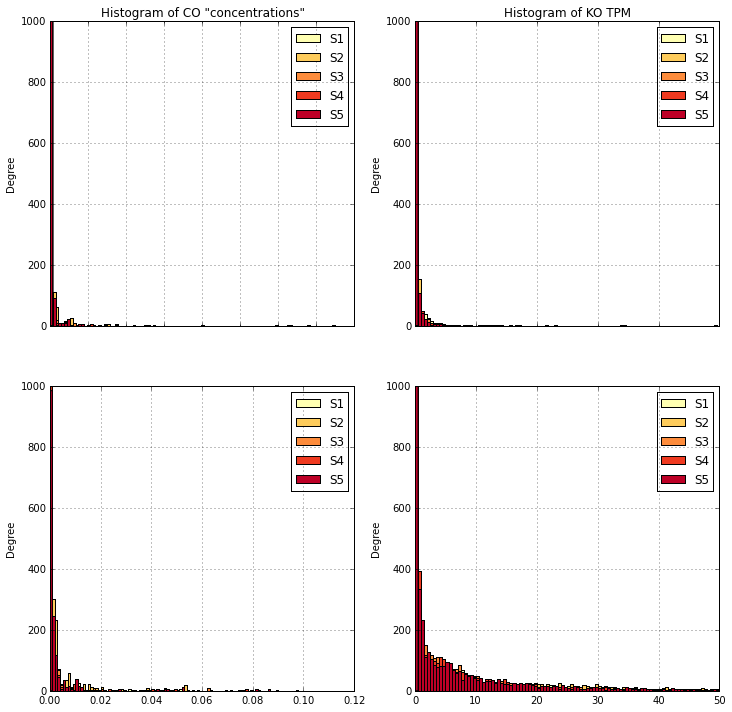

In [434]:
cmap=pal.colorbrewer.sequential.YlOrRd_5.get_mpl_colormap()
fig, axs=plt.subplots(2,2) 
fig.set_size_inches(12,12)
for ax in axs:
    for a in ax: 
        a.set_ylim([0,1000])
CO_RawData.plot(kind='hist', bins=100,colormap=cmap, ax=axs[0][0])
axs[0][0].set_title('Histogram of CO "concentrations"', size='large')
KO_RawData.plot(kind='hist', bins=100,colormap=cmap,ax=axs[0][1])
axs[0][1].set_title('Histogram of KO TPM', size='large')
CO_RawData.plot(kind='hist',  bins=100,colormap=cmap, range = [0,0.1],ax=axs[1][0])
KO_RawData.plot(kind='hist',  bins=100,colormap=cmap, range = [0,50],ax=axs[1][1])

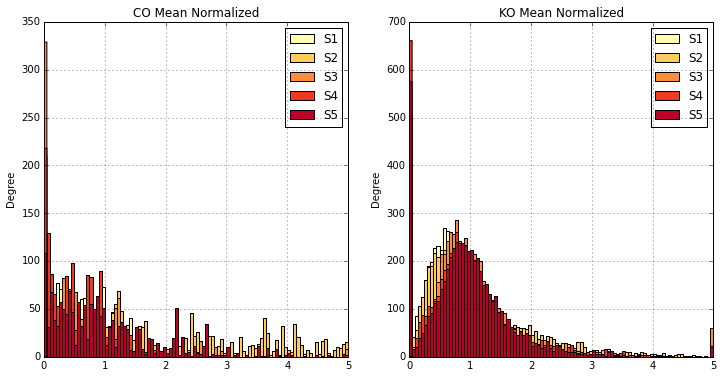

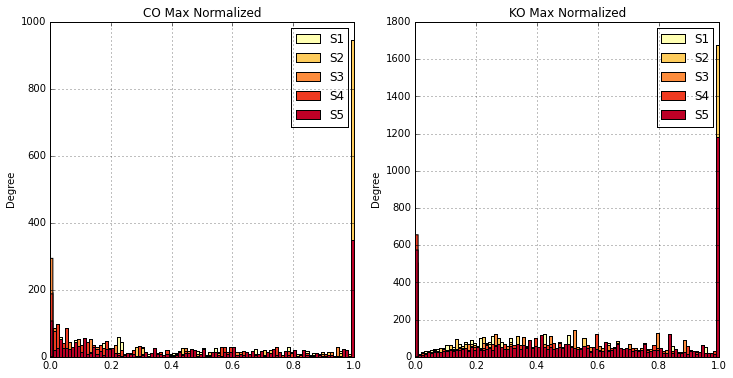

In [435]:
def NormalizeToMean(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['mean']=DF.mean(axis=1)

    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['mean']
    DF_meanNorm=DF_meanNorm.T.drop('mean').T
    return out


def NormalizeToMax(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['max']=DF.max(axis=1)
    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['max']
    DF_meanNorm=DF_meanNorm.T.drop('max').T
    return out

#several options for normalizing the data
CO_Norm2Mean=NormalizeToMean(CO_RawData) #this is what gets used in the original code
KO_Norm2Mean=NormalizeToMean(KO_RawData) #this is what gets used in the original code
CO_Norm2Max=NormalizeToMax(CO_RawData)
KO_Norm2Max=NormalizeToMax(KO_RawData)

cmap=pal.colorbrewer.sequential.YlOrRd_5.get_mpl_colormap()

fig, axs=plt.subplots(1,2) 
fig.set_size_inches(12,6)

kplt=KO_Norm2Mean.plot(kind='hist', bins=100, title='KO Mean Normalized', colormap=cmap, ax=axs[1])
cplt=CO_Norm2Mean.plot(kind='hist', bins=100, title='CO Mean Normalized', colormap=cmap, ax=axs[0])
fig, axs=plt.subplots(1,2) 
fig.set_size_inches(12,6)

kplt=KO_Norm2Max.plot(kind='hist', bins=100, title='KO Max Normalized', colormap=cmap, ax=axs[1])
cplt=CO_Norm2Max.plot(kind='hist', bins=100, title='CO Max Normalized', colormap=cmap, ax=axs[0])

For the moment, I am ignoring the various data normalization options (KL, 8/24/2015).

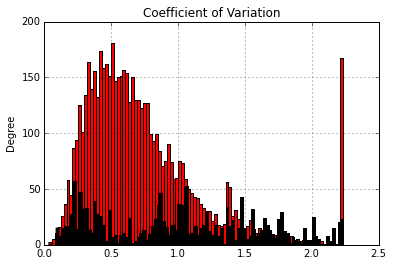

In [436]:
def NormalizeToMean_CV(DF):
    out=DF.copy()
    out['mean']=DF.mean(axis=1)
    out['SD']=DF.std(axis=1)
    
    out['CV']=out['SD']/out['mean']
    return out

cmap=pal.colorbrewer.diverging.PRGn_5.get_mpl_colormap()
fig,ax=plt.subplots(1)
CO_CV=NormalizeToMean_CV(CO_RawData)
KO_CV=NormalizeToMean_CV(KO_RawData)
# KO_CV.CV.plot(kind='hist', ax=ax, bins=100, title='CO Mean Normalized', colormap=cmap)
KO_CV.CV.plot(kind='hist', ax=ax, bins=100, color='r')
CO_CV.CV.plot(kind='hist', ax=ax, bins=100, title='Coefficient of Variation', color='k')
fig.savefig('Coefficent of Variation')



This grabs the CO/KO links from the KEGG website. The actual code is in the CreateHash_COtoKO.py that Harriet wrote. Note that since the exportMetabolites.csv file is in effect a unique list of C number we essentially already have a lookup table for all the metabolites of interest.

In [437]:
#filename = "CreateHash_COtoKO.py"
#%run $filename $mtabFile  #this version uses mtabFile to store the CSV file name
# 'exportMetabolites.csv'

# filename = "CreateHash_COtoKO.py"
# %run $filename exportMetabolites.csv 


In [438]:
import cPickle as cpk

In [439]:
#already ran the code earlier, so just need to read it in again. 
WorkingFile = cpk.load(open('running_Script.pickle','r'))

In [440]:
def SplitCODict(WorkingFile):
    CO_withoutKO={}
    CO_withKO={}
    for CO in WorkingFile.keys():

        if WorkingFile[CO]['Related KO']==[]:
            CO_withoutKO[CO]=WorkingFile[CO]
        else:
            CO_withKO[CO]=WorkingFile[CO]
    return CO_withoutKO, CO_withKO

CO_withoutKO, CO_withKO=SplitCODict(WorkingFile)
print 'There are', len(CO_withKO), 'COs with an associated KO.', len(CO_withoutKO), 'are not associated with a KO.'



There are 303 COs with an associated KO. 1036 are not associated with a KO.


In [441]:
AllKO=[]
AllCO=[]
for key in CO_withKO:
    AllKO.append(CO_withKO[key]['Related KO'])
    AllCO.append(CO_withKO[key]['Related CO'])
AllKO=list(set([item for sublist in AllKO for item in sublist]))
AllCO=list(set([item for sublist in AllCO for item in sublist]))

# KO_limited_Norm2Mean=KO_Norm2Mean.loc[AllKO].dropna()
# CO_limited_Norm2Mean=CO_Norm2Mean.loc[AllCO].dropna()

In [442]:
KO_limited_Norm2Mean=KO_Norm2Mean.loc[AllKO].dropna()

In [443]:
# df.ix[0,'cNumber'] #this will allow me to mix integers with labels
#more current way apparently uses iloc and loc, to use integers and labels respectively
# this would be df.iloc[0].loc['cNumber] {can't get that to work in the if statement}
#go through CO_RawData_all one row at a time (inefficient for sure, but I understand what is happening)
#make a new column in CO_RawData_all
CO_RawData_all['new'] = ""

for idx in range(0,len(CO_RawData_all)):
# for idx in range(0):
    fc = CO_RawData_all.ix[idx,'cNumber']
    if fc in AllCO:
        CO_RawData_all.ix[idx,'new'] = True
    else:
        CO_RawData_all.ix[idx,'new'] = False  

In [444]:
CO_RawData_all.head(5)

,cNumber,S1,S2,S3,S4,S5,new
RInumber,,,,,,,
RI1,C00047,0.000841,0.001725,0.001201,0.000771,0.000604,True
RI2,C00078,0.005920,0.007708,0.003950,0.010562,0.027481,True
RI3,C00079,0.000229,0.000310,0.000320,0.000169,0.000356,True
RI4,C00079,0.002722,0.004054,0.002479,0.002422,0.001029,True
RI5,C00079,0.031454,0.045236,0.017831,0.040436,0.086708,True


In [445]:
#this might be roundabout...but now it seems like I should be able to filter my CO_RawData_all 
#and keep things where new = True
newCO = CO_RawData_all[CO_RawData_all['new']==True]

In [446]:
newCO.head(5)

,cNumber,S1,S2,S3,S4,S5,new
RInumber,,,,,,,
RI1,C00047,0.000841,0.001725,0.001201,0.000771,0.000604,True
RI2,C00078,0.005920,0.007708,0.003950,0.010562,0.027481,True
RI3,C00079,0.000229,0.000310,0.000320,0.000169,0.000356,True
RI4,C00079,0.002722,0.004054,0.002479,0.002422,0.001029,True
RI5,C00079,0.031454,0.045236,0.017831,0.040436,0.086708,True


In [447]:
#repeat the normalization from way above...NormalizeToMean has already been defined as a function above
#but...be careful here because now I have more columns...
df = newCO[['S1','S2','S3','S4','S5']]
df2=NormalizeToMean(df) #this is what gets used in the original code
df2.head(5)

,S1,S2,S3,S4,S5
RInumber,,,,,
RI1,0.817390,1.677623,1.167981,0.749697,0.587309
RI2,0.532171,0.692874,0.355094,0.949504,2.470356
RI3,0.828302,1.119413,1.155018,0.611070,1.286197
RI4,1.071312,1.595462,0.975371,0.953067,0.404787
RI5,0.709497,1.020376,0.402216,0.912087,1.955824


In [448]:
#perhaps I can just insert that back into newCO...?
# newCO.loc[:,'S1'] = df2.loc[:,'S1']
newCO.loc[:,('S1','S2','S3','S4','S5')] = df2.loc[:,('S1','S2','S3','S4','S5')]

In [449]:
newCO.head(5)

,cNumber,S1,S2,S3,S4,S5,new
RInumber,,,,,,,
RI1,C00047,0.817390,1.677623,1.167981,0.749697,0.587309,True
RI2,C00078,0.532171,0.692874,0.355094,0.949504,2.470356,True
RI3,C00079,0.828302,1.119413,1.155018,0.611070,1.286197,True
RI4,C00079,1.071312,1.595462,0.975371,0.953067,0.404787,True
RI5,C00079,0.709497,1.020376,0.402216,0.912087,1.955824,True


In [450]:
#can delete 'new' column as that will always be true
newCO = newCO.drop('new',1)

In [451]:
CO_limited_Norm2Mean=newCO.dropna()

In [452]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

def kmeanCluster(data,nc):
    kmeans=KMeans(n_clusters=nc)
    kmeans.fit(data)
    newData=data.copy()
    newData['kmeans']=kmeans.labels_
    return newData
def silhoetteAnalysis(X, range_n_clusters):

    # Generating the sample data from make_blobs
    # This particular setting has one distict cluster and 3 clusters placed close
    # together.
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
         #ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

def PlotKmeans(KmeansPD, kSize=10, figSizeX=1, figSizeY=5, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color=color)
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(9,12)
    for ax, y in zip(axs,range(kSize)):
        pltData=KmeansPD[KmeansPD.kmeans==y].T.drop('kmeans')
        pltData.plot(ax=ax, legend=False, grid=False, color=color)

Built-in functions, exceptions, and other objects.

Noteworthy: None is the `nil' object; Ellipsis represents `...' in slices.


So...how do we actually decide how many clusters are best? Using silhoette analysis, looking for high silhouette_scores. For now I have set this to only look at a few options. However, there are also good silhoette scores with 2-5 clusters as well.

('For n_clusters =', 11, 'The average silhouette_score is :', 0.2581578711333411)


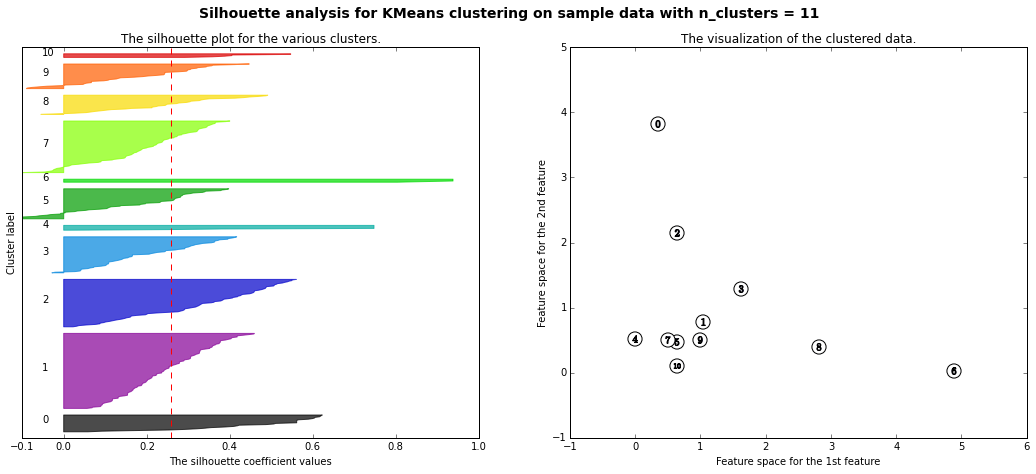

('For n_clusters =', 12, 'The average silhouette_score is :', 0.25371022390988685)


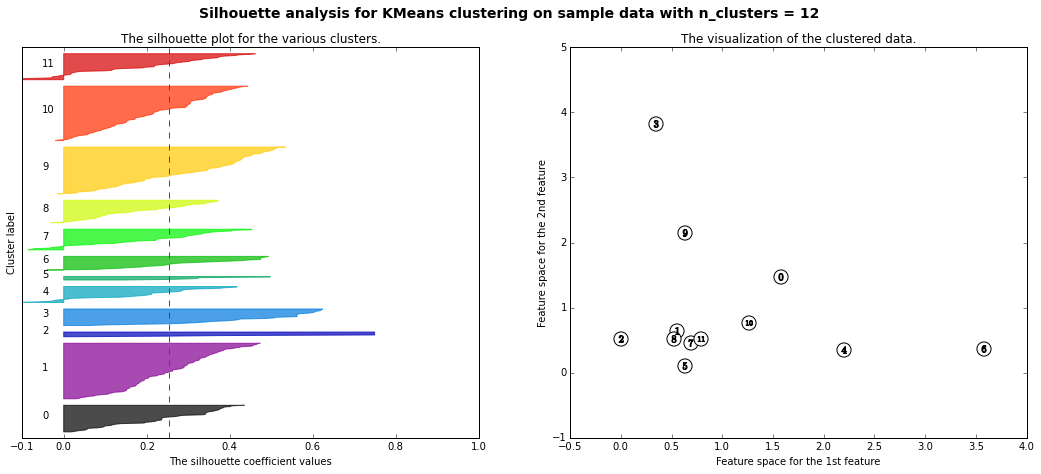

In [453]:
#Silhoette data to determine optimal number of clusters. Start with the KO data
silhoetteAnalysis(KO_limited_Norm2Mean, np.arange(11,13,1))

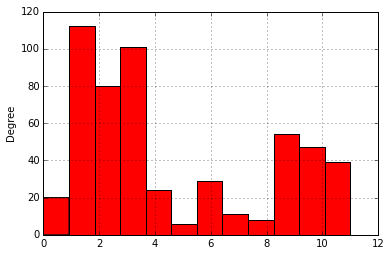

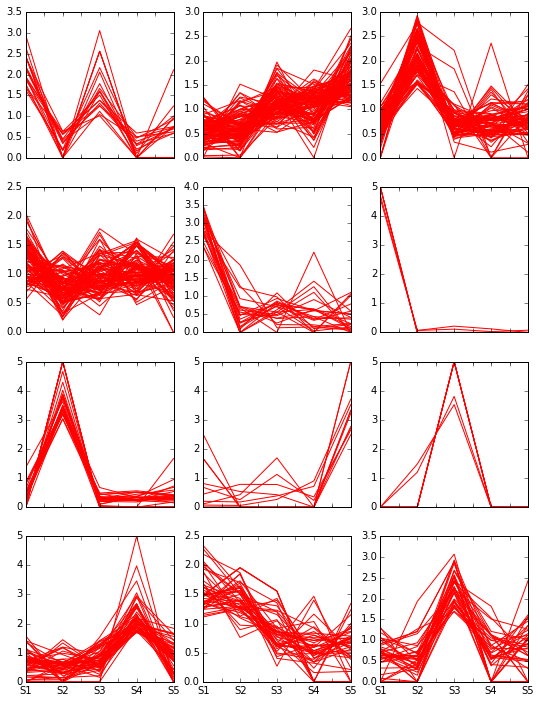

In [454]:
#plot it up...
#koClust=kmeanCluster(KO_limited_Norm2Mean, 15)
#PlotKmeans(koClust,15,3,5, 'r') 
koClust=kmeanCluster(KO_limited_Norm2Mean, 12)
PlotKmeans(koClust,12,4,3, 'r') 


In [455]:
CO_limited_Norm2Mean.head(5)

,cNumber,S1,S2,S3,S4,S5
RInumber,,,,,,
RI1,C00047,0.817390,1.677623,1.167981,0.749697,0.587309
RI2,C00078,0.532171,0.692874,0.355094,0.949504,2.470356
RI3,C00079,0.828302,1.119413,1.155018,0.611070,1.286197
RI4,C00079,1.071312,1.595462,0.975371,0.953067,0.404787
RI5,C00079,0.709497,1.020376,0.402216,0.912087,1.955824


('For n_clusters =', 11, 'The average silhouette_score is :', 0.42768237676623005)


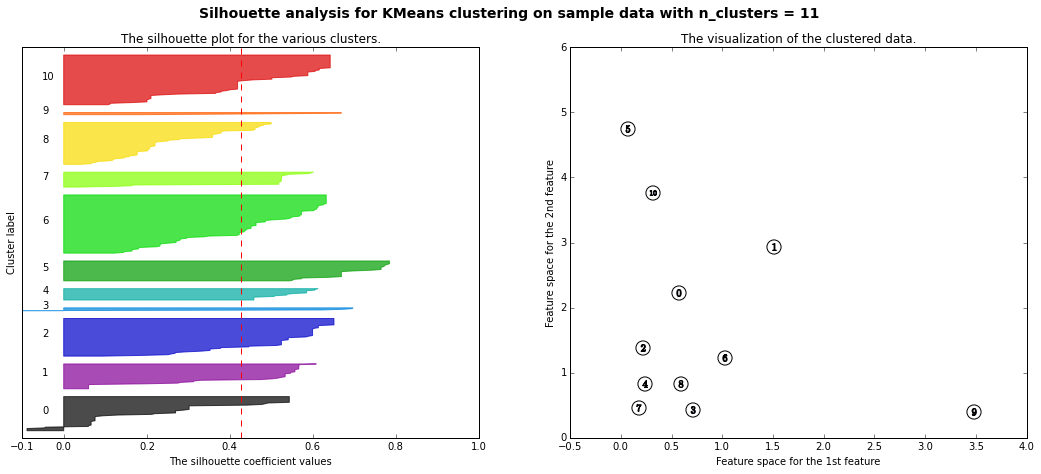

('For n_clusters =', 12, 'The average silhouette_score is :', 0.42301587225890103)


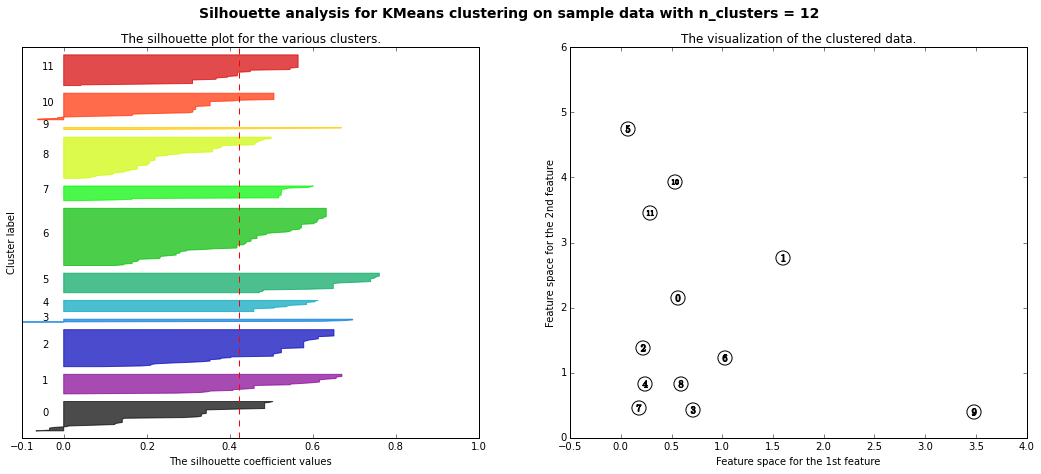

In [456]:
#now do the CO data
#silhoetteAnalysis(CO_limited_Norm2Mean, np.arange(2,20,1)) #KL trying a large range of options
silhoetteAnalysis(CO_limited_Norm2Mean.loc[:,('S1','S2','S3','S4','S5')], np.arange(11,13,1))

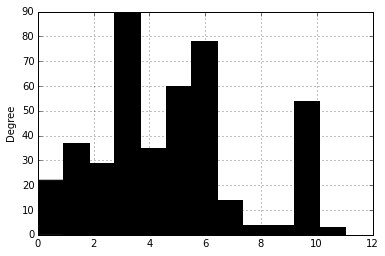

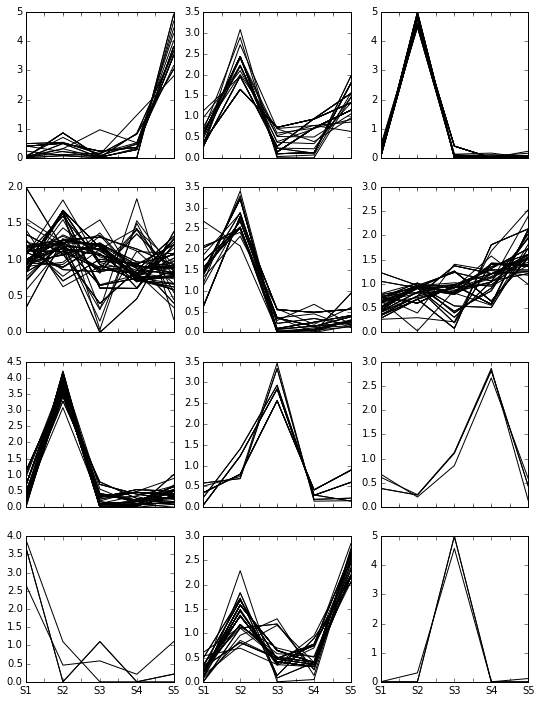

In [457]:
#coClust=kmeanCluster(CO_limited_Norm2Mean, 15)
#PlotKmeans(coClust,15,3,5, 'k') 
coClust=kmeanCluster(CO_limited_Norm2Mean.loc[:,('S1','S2','S3','S4','S5')], 12)
PlotKmeans(coClust,12,4,3, 'k') 

From HA: By normalizing the data to the mean we can then (in theory) combine the two and cluster them together?
KL 8/20/2015 note: this is essentially a list with the CO and KO concatenated into a single data frame. Note that the actual kmeans clustering does not happen until after the silhoette analysis.

('For n_clusters =', 2, 'The average silhouette_score is :', 0.42276349455398421)


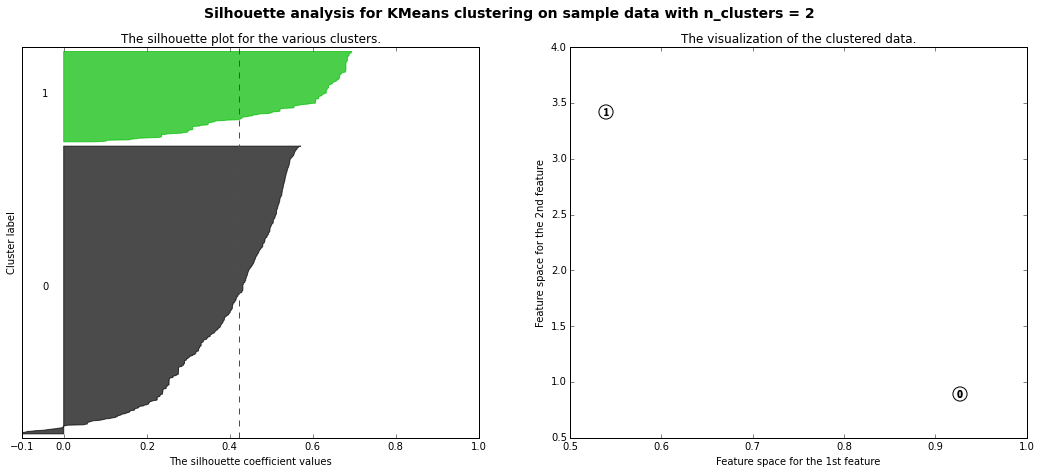

('For n_clusters =', 3, 'The average silhouette_score is :', 0.33299148272143164)


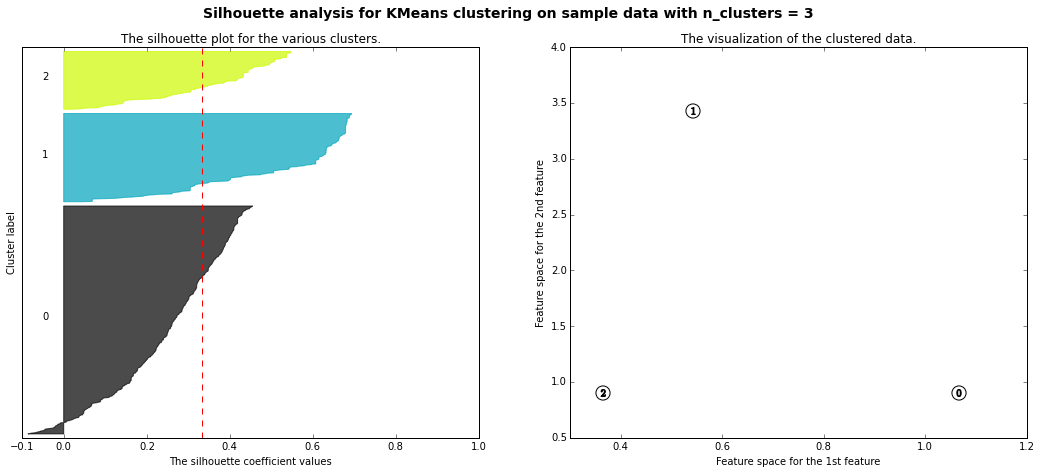

('For n_clusters =', 4, 'The average silhouette_score is :', 0.35461544374574627)


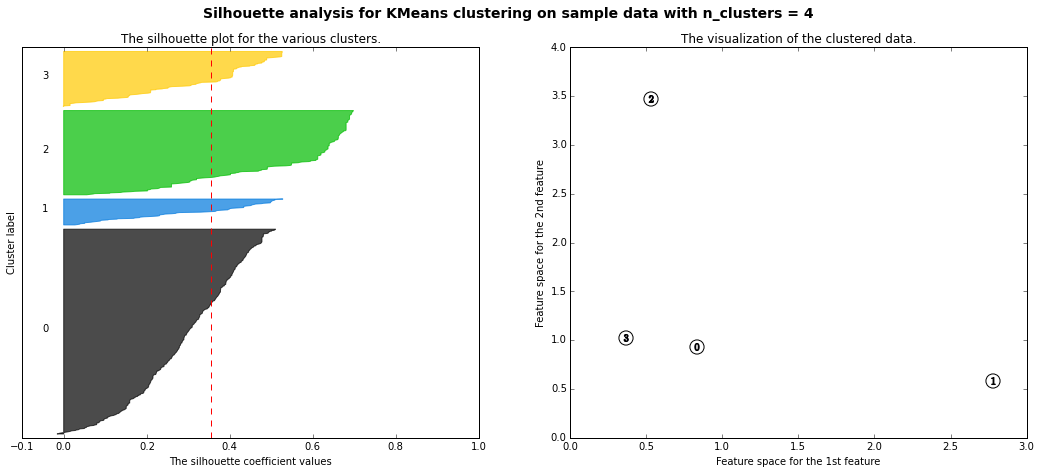

('For n_clusters =', 5, 'The average silhouette_score is :', 0.37685223360686287)


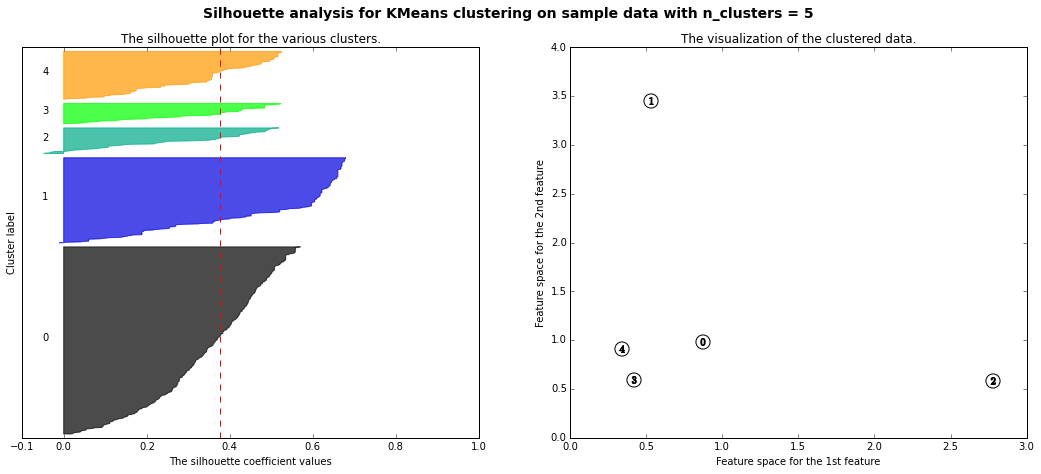

('For n_clusters =', 6, 'The average silhouette_score is :', 0.33623123630362411)


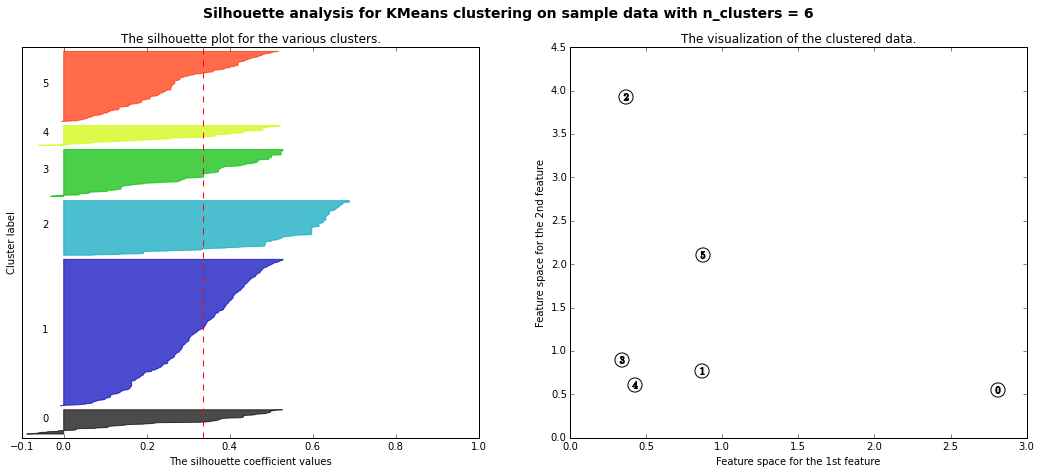

('For n_clusters =', 7, 'The average silhouette_score is :', 0.30148510827954256)


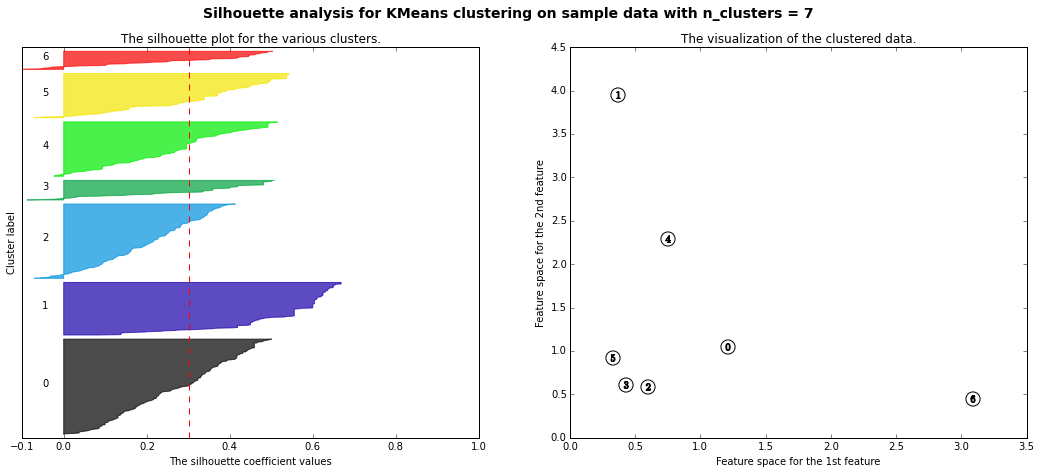

('For n_clusters =', 8, 'The average silhouette_score is :', 0.30416240439356534)


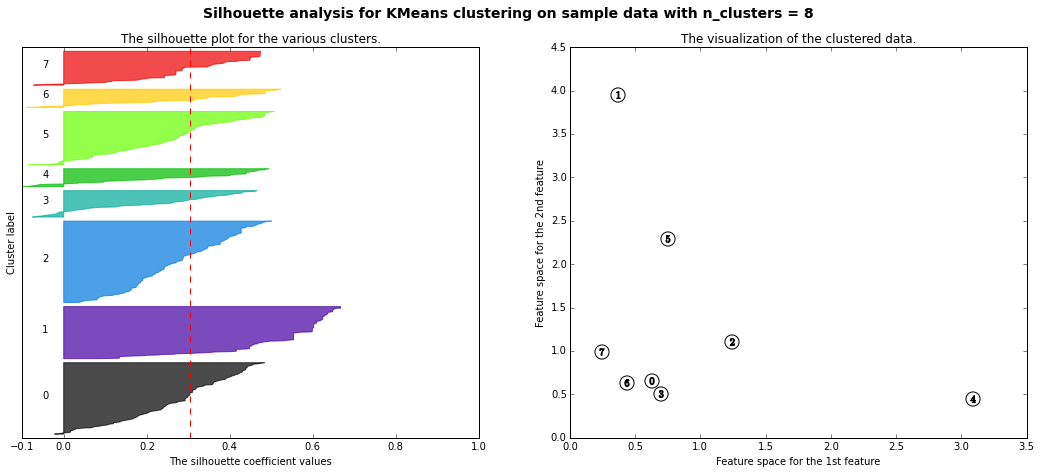

('For n_clusters =', 9, 'The average silhouette_score is :', 0.30736536958935512)


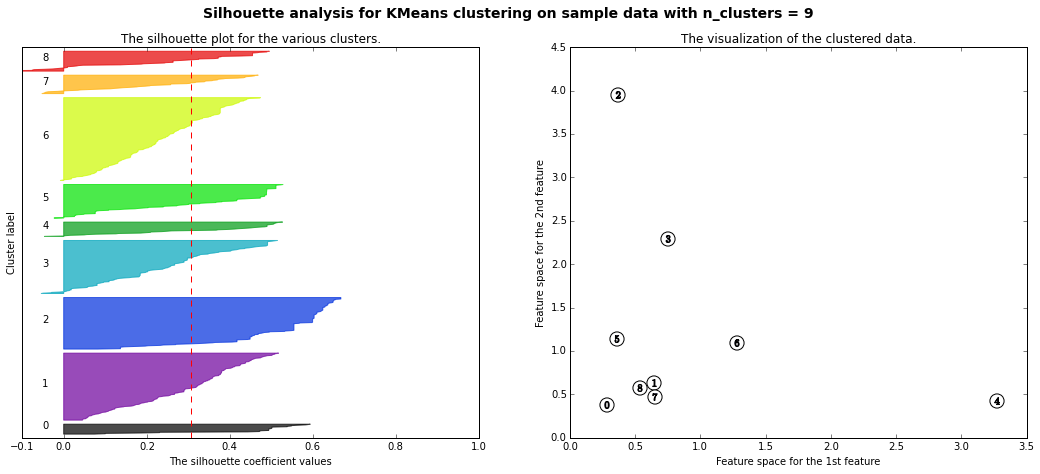

('For n_clusters =', 10, 'The average silhouette_score is :', 0.31391525764864214)


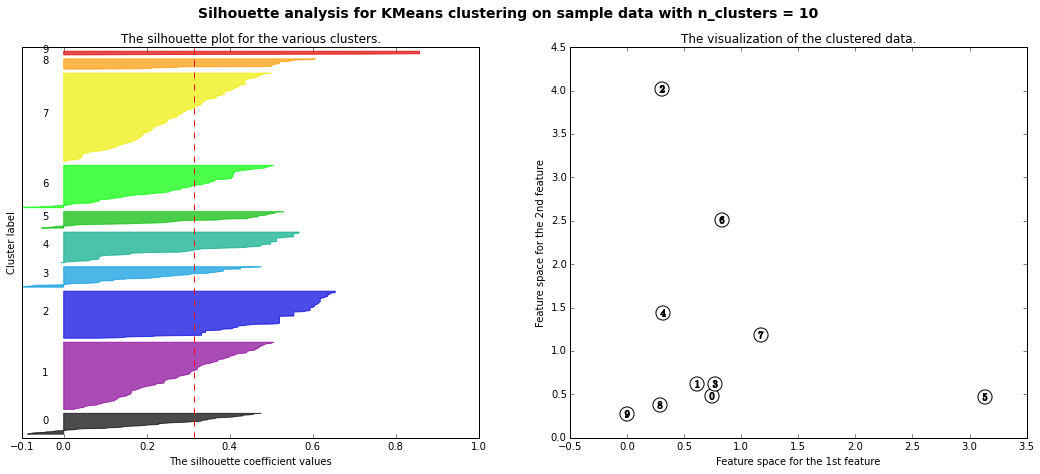

('For n_clusters =', 11, 'The average silhouette_score is :', 0.32524451677179372)


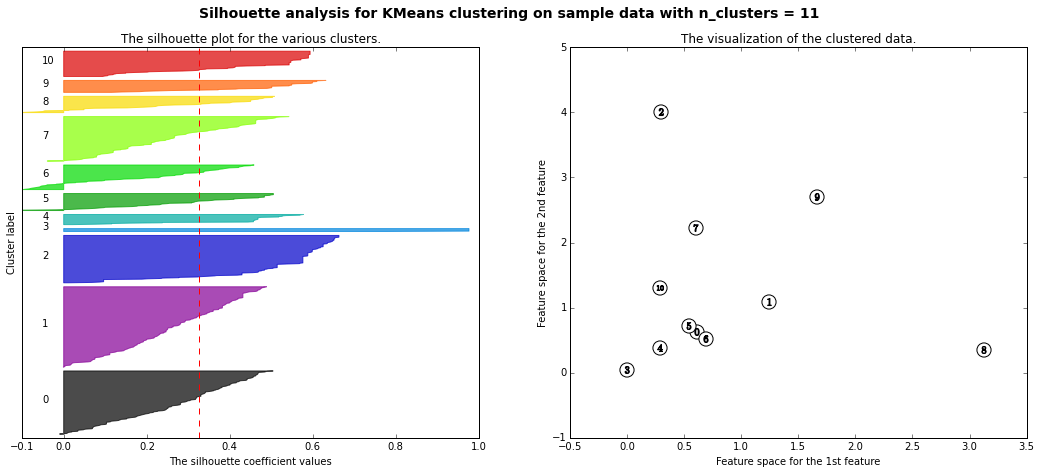

('For n_clusters =', 12, 'The average silhouette_score is :', 0.31092904248383479)


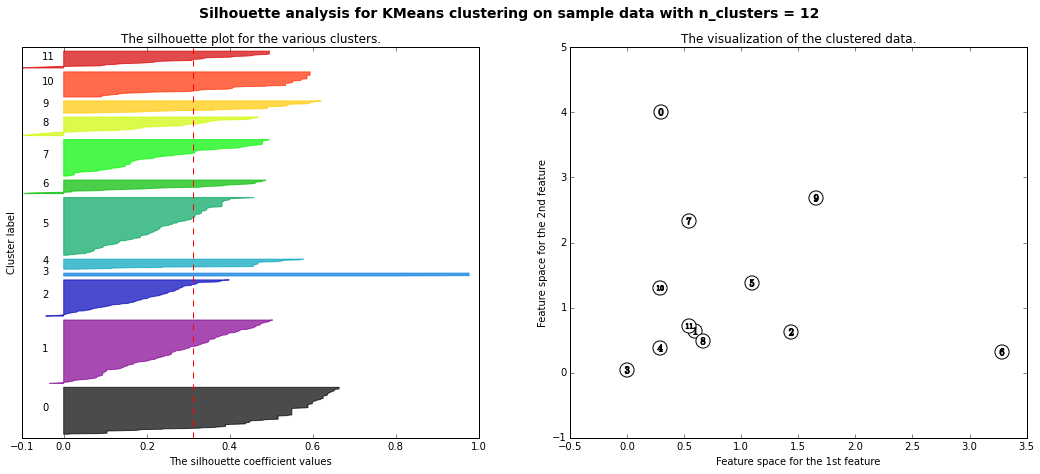

('For n_clusters =', 13, 'The average silhouette_score is :', 0.29992799728043579)


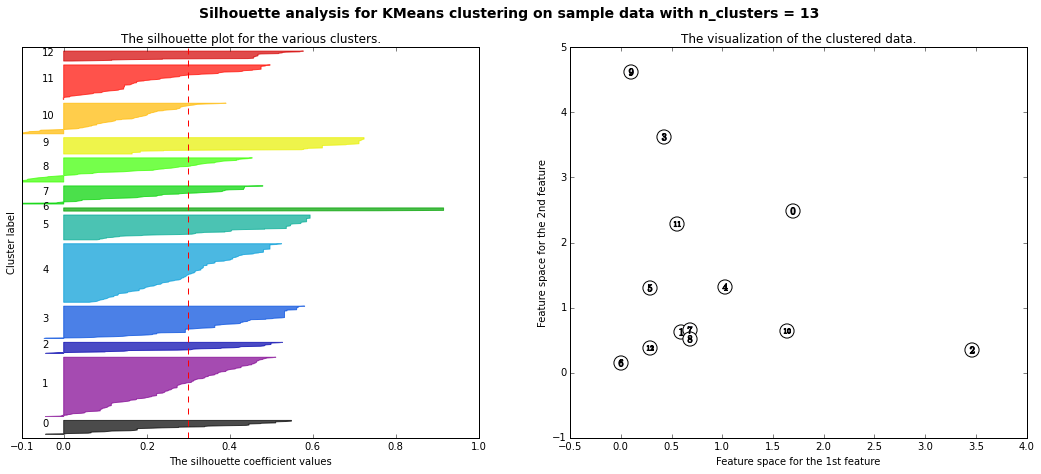

('For n_clusters =', 14, 'The average silhouette_score is :', 0.2938619783212616)


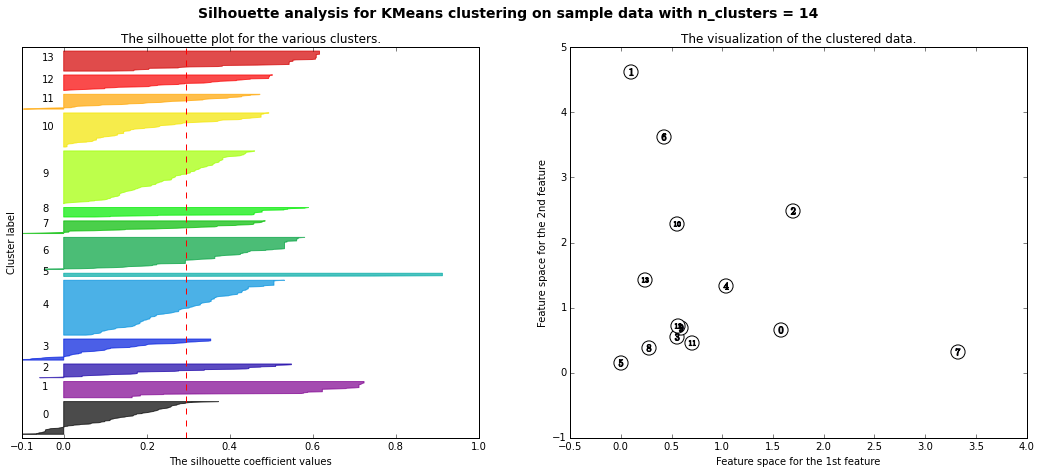

('For n_clusters =', 15, 'The average silhouette_score is :', 0.28904670351846906)


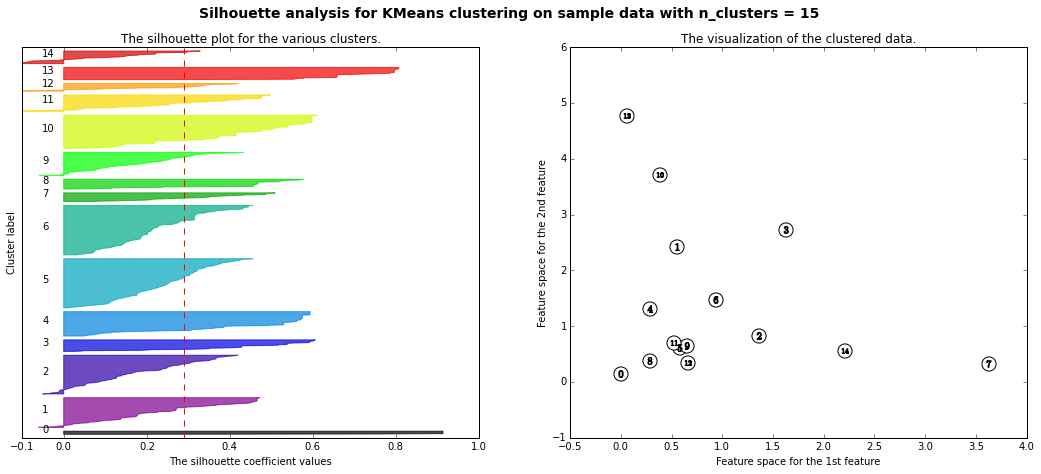

('For n_clusters =', 16, 'The average silhouette_score is :', 0.29386003590453863)


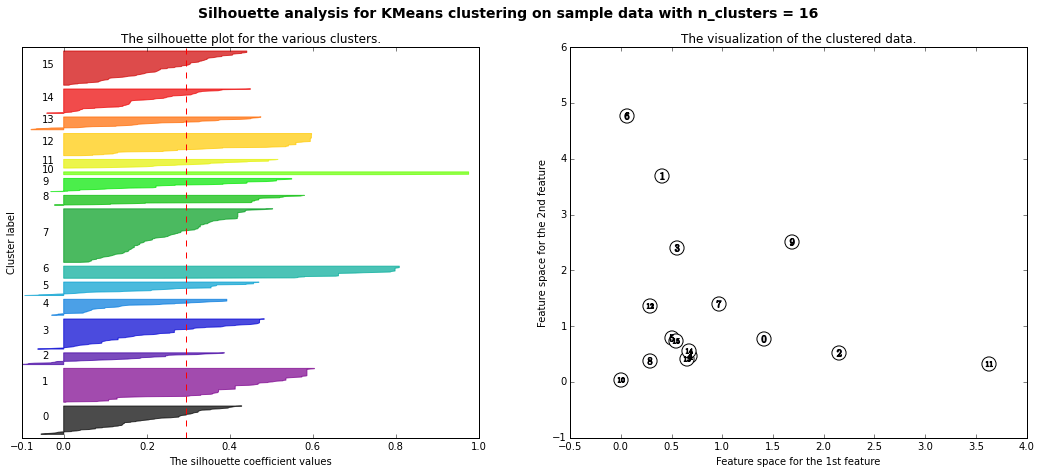

('For n_clusters =', 17, 'The average silhouette_score is :', 0.29086078806277699)


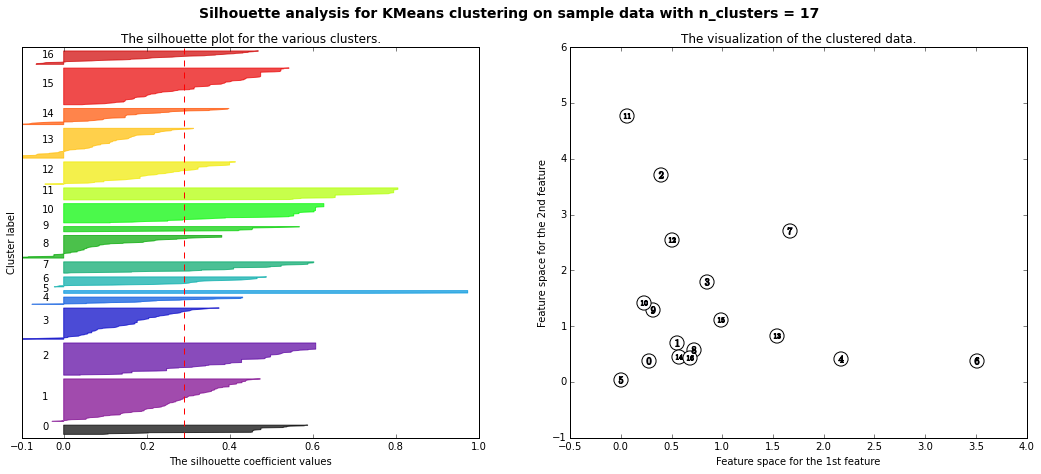

('For n_clusters =', 18, 'The average silhouette_score is :', 0.28847126011322971)


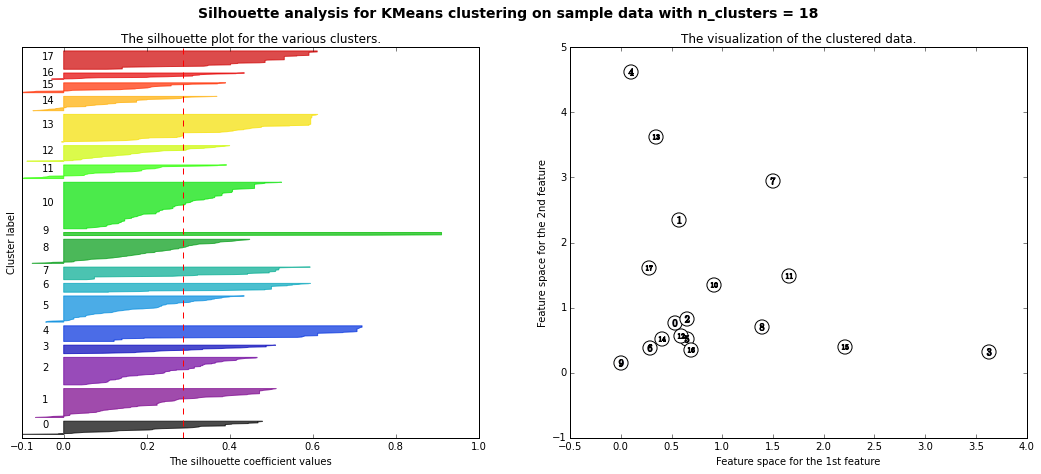

('For n_clusters =', 19, 'The average silhouette_score is :', 0.30002448783975649)


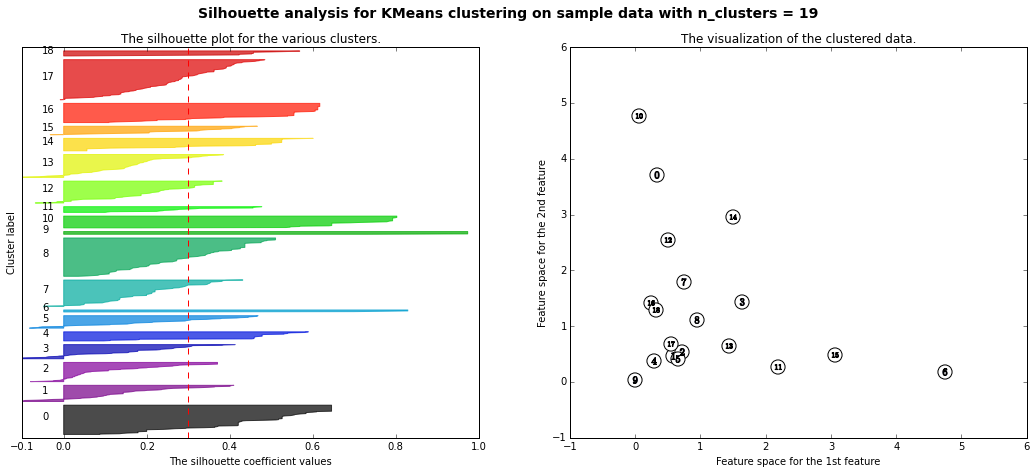

('For n_clusters =', 20, 'The average silhouette_score is :', 0.28747030795501188)


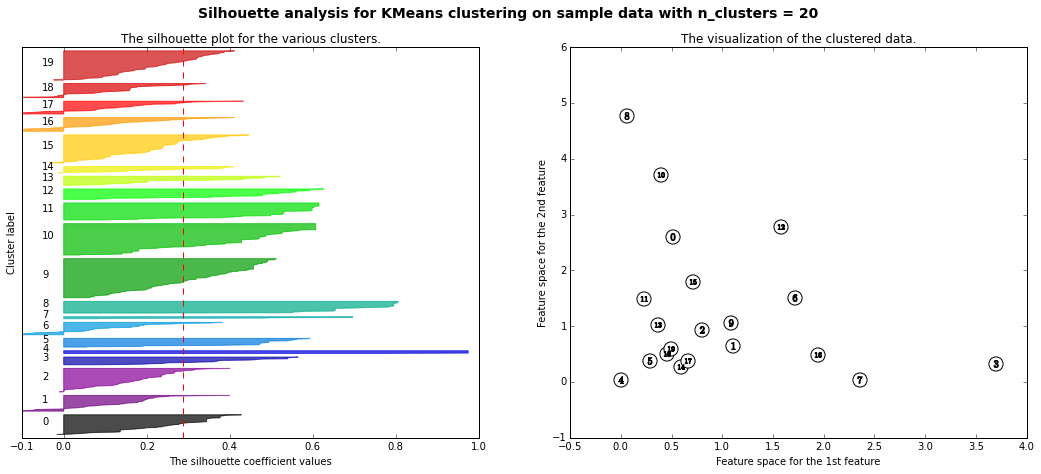

In [458]:
#Combined_KO_CO_MeanNorm=KO_limited_Norm2Mean.append(CO_limited_Norm2Mean)
Combined_KO_CO_MeanNorm=KO_limited_Norm2Mean.append(CO_limited_Norm2Mean.loc[:,('S1','S2','S3','S4','S5')])
#
# Combined_KO_CO_MeanNorm=Combined_KO_CO_MeanNorm-Combined_KO_CO_MeanNorm.mean()
#Run silhoette analysis
#silhoetteAnalysis(Combined_KO_CO_MeanNorm, np.arange(15,19,1))
silhoetteAnalysis(Combined_KO_CO_MeanNorm, np.arange(2,21,1))

Here I am going with 12 clusters, but I have no actual good reason for that number yet

In [459]:
CcoClust=kmeanCluster(Combined_KO_CO_MeanNorm, 8) #was 18 

In [460]:
CcoClust.head(5)

,S1,S2,S3,S4,S5,kmeans
K17687,0.471030,0.484041,1.538987,1.363316,1.142626,7
K00817,1.631601,1.314645,0.814735,0.498653,0.740367,2
K17724,2.438723,0.000000,2.561277,0.000000,0.000000,6
K06164,1.941547,0.000000,3.058453,0.000000,0.000000,5
K03147,0.813638,0.645428,0.402607,2.271505,0.866822,1


In [461]:
#note the RI numbers in here...
CcoClust.tail(5)

,S1,S2,S3,S4,S5,kmeans
RI1580,0.371941,1.643662,0.730761,0.930586,1.323049,0
RI1581,0.621108,2.789395,0.549260,0.483234,0.557003,0
RI1604,0.371941,1.643662,0.730761,0.930586,1.323049,0
RI1605,0.621108,2.789395,0.549260,0.483234,0.557003,0
RI1613,0.143164,4.736745,0.030718,0.034203,0.055169,4


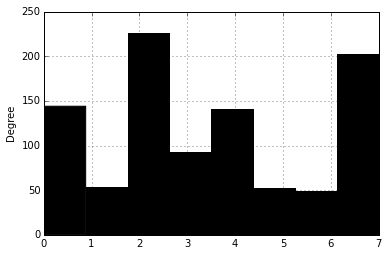

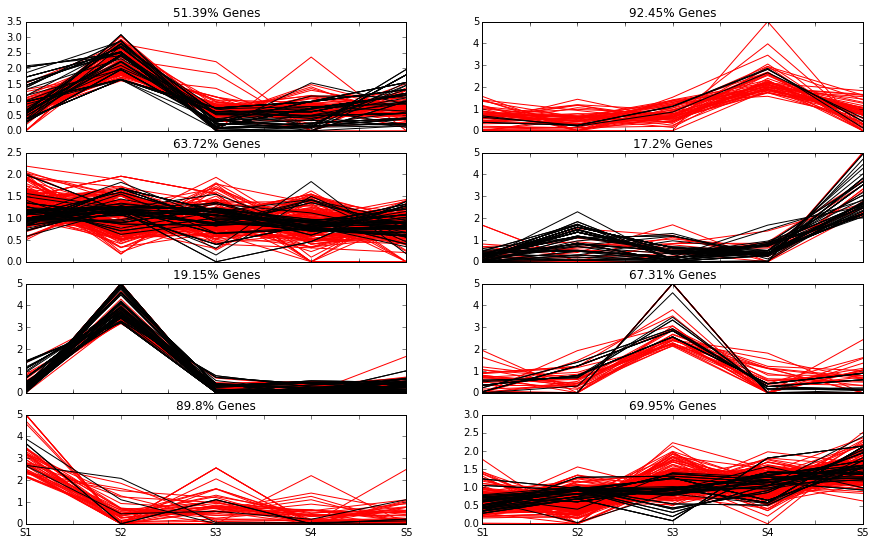

In [462]:
def PlotKmeansCombined(KmeansPD, kSize=10, figSizeX=1, figSizeY=5, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color='k')
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(15,9)
    i=KmeansPD.index
    i=list(i)
    Ks=re.compile('K.*')
    #Cs=re.compile('C.*')
    Cs = re.compile('R.*') #this is the RInumber I created...for the moment, do not need the Cnumber
    C = filter(Cs.search, i)  
    K = filter(Ks.search, i)  
    Ksplit=KmeansPD.loc[K]
    Csplit=KmeansPD.loc[C]
    for ax, y in zip(axs,range(kSize)):
        KData=Ksplit[Ksplit.kmeans==y].T.drop('kmeans')
        KData.plot(ax=ax, legend=False, grid=False, color='r')
        CData=Csplit[Csplit.kmeans==y].T.drop('kmeans')
        CData.plot(ax=ax, legend=False, grid=False, color='k')
        SumKC=len(KData.T)+len(CData.T)
        KPct=float(len(KData.T))/SumKC*100
        CPct=float(len(CData.T))/SumKC*100
        ax.set_title(str(round(KPct,2))+'% Genes')
    

#PlotKmeansCombined(CcoClust,18,3,6, 'r') 
PlotKmeansCombined(CcoClust,8,4,2, 'r') 

But...for the CheckRelatedness...do need to go back to the cNumber...easiest to just make yet another matrix, now putting the cNumbers back in. 

In [463]:
CO_RawData_all.tail(5)

,cNumber,S1,S2,S3,S4,S5,new
RInumber,,,,,,,
RI1610,C18133,0.000000,0.000000,0.000011,0.000000,0.000000,False
RI1611,C18171,0.003863,0.020938,0.007116,0.023012,0.045452,False
RI1612,C18176,0.003863,0.020938,0.007116,0.023012,0.045452,False
RI1613,C18218,0.000372,0.012305,0.000080,0.000089,0.000143,True
RI1614,C18316,0.001095,0.001586,0.002181,0.001113,0.002657,False


In [464]:
CcoClust.tail(5)

,S1,S2,S3,S4,S5,kmeans
RI1580,0.371941,1.643662,0.730761,0.930586,1.323049,0
RI1581,0.621108,2.789395,0.549260,0.483234,0.557003,0
RI1604,0.371941,1.643662,0.730761,0.930586,1.323049,0
RI1605,0.621108,2.789395,0.549260,0.483234,0.557003,0
RI1613,0.143164,4.736745,0.030718,0.034203,0.055169,4


In [465]:
#don't want to overwrite CcoClust in case I screw up here.
del forRelatedness
#forRelatedness = CcoClust# this is NOT making a new copy...instead making changes that apply to both dataframes. Odd.
forRelatedness = CcoClust.copy(deep=True)
type(forRelatedness)
forRelatedness.insert(0,'KEGG',"")
forRelatedness.head(5)

,KEGG,S1,S2,S3,S4,S5,kmeans
K17687,,0.471030,0.484041,1.538987,1.363316,1.142626,7
K00817,,1.631601,1.314645,0.814735,0.498653,0.740367,2
K17724,,2.438723,0.000000,2.561277,0.000000,0.000000,6
K06164,,1.941547,0.000000,3.058453,0.000000,0.000000,5
K03147,,0.813638,0.645428,0.402607,2.271505,0.866822,1


In [466]:
for idx in range(0,len(forRelatedness)-1):
    t = forRelatedness.iloc[idx,:].name

    if t[0]=='R':
        #go find the matching cNumber in CO_RawData_all
        t2 = CO_RawData_all.loc[t,('cNumber')]
        forRelatedness.ix[idx,('KEGG')] = t2
    elif t[0] == 'K':
        #just copy the K number over
        forRelatedness.ix[idx,('KEGG')] = t

In [467]:
forRelatedness.head(5)

,KEGG,S1,S2,S3,S4,S5,kmeans
K17687,K17687,0.471030,0.484041,1.538987,1.363316,1.142626,7
K00817,K00817,1.631601,1.314645,0.814735,0.498653,0.740367,2
K17724,K17724,2.438723,0.000000,2.561277,0.000000,0.000000,6
K06164,K06164,1.941547,0.000000,3.058453,0.000000,0.000000,5
K03147,K03147,0.813638,0.645428,0.402607,2.271505,0.866822,1


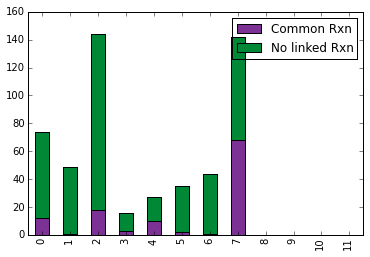

In [468]:
def CheckRelatedness(inClust,nC):
    df=pd.DataFrame(columns=['Common Rxn','No linked Rxn'], index=range(nC))
    for n in range(nC):
        kClust=inClust[inClust.kmeans==n]
        #i=kClust.index
        i = kClust.KEGG #change the new column I created ...
        i=list(i)
        #can't search on C numbers...because right now the data are RInumbers
        #seems like I need to set which columns it is searching here...or how did Harriet get around that?
        Csearc=re.compile('C.*') #re is regular expression...perl-like; re.compile bascially makes an object
        Cs = filter(Csearc.search, i)
        Ksearc=re.compile('K.*')
        Kis = filter(Ksearc.search, i)
        Kis=set(Kis)
        Ks=[]
        for c in Cs:
            if c in CO_withKO.keys():
                Ks.append(CO_withKO[c]['Related KO'])
        Ks=set([item for sublist in Ks for item in sublist])
        df.loc[n,'Common Rxn']=len(Kis.intersection(Ks))
        df.loc[n, 'No linked Rxn']=len(Kis)-len(Kis.intersection(Ks))
    df.plot(kind='bar', stacked=True, colormap=pal.colorbrewer.diverging.PRGn_5.get_mpl_colormap(), grid=False)
    
    
CheckRelatedness(forRelatedness, 12)

Seems like I want to plot the various CO/KO combined plots by clusters shown in the k-means clustering. What would be nice is to group the plots from the related compounds by cluster...this is the point where I realized that there is no way around track the KEGG compounds with something other than the CO number since that will not be unique.

Now I have a new variable (RInumber) which has an arbitrary number for each mzRT feature and has the same number of rows as the original CO data...eek, as low as no rows were deleted.

In [469]:
#from IPython.core.debugger import Tracer #used this to step into the function and debug it, also need line with Tracer()() 

for i, CO in enumerate(CO_withKO):
    if i==20:
         break
    kos=CO_withKO[CO]['Related KO']
    cos=CO_withKO[CO]['Related CO']
    for k in kos: 
        if k in KO_RawData.index: 
            kData=KO_RawData.loc[kos].dropna()
            kData=(kData.T/kData.sum(axis=1)).T
            cData=CO_RawData.loc[cos].dropna()
            cData=(cData.T/cData.sum(axis=1)).T
            
            fig, ax=plt.subplots(1)
            kData.T.plot(color='r', ax=ax)
            cData.T.plot(color='k', ax=ax)
            
            #Tracer()()
            
            getKmeans = CcoClust.loc[CO]['kmeans']
            #this point is what raised the questions about tracking cNumbers: they are not unique. Drat.
            makeStringLabel = 'kmeansCluster_' + str(getKmeans) + '_' + CO
            #fig.suptitle(CO)
            fig.suptitle(makeStringLabel)
            
            #fig.savefig(makeStringLabel+'.png') #savefig will break until I figure out a better way to track the isomers 
            break

KeyError: "None of [['C01909', 'C00120', 'C00009', 'C00080', 'C00019', 'C17023', 'C00008', 'C00002', 'C00011', 'C05359', 'C05198', 'C00073', 'C01037']] are in the [index]"